# FIT5149 - Applied Data Analysis
## Assignment 2 - Group 1
## Student name - ID
### Duy Tho Le - 30902819
### Minh Thai Nguyen - 30910099
### Duy Ngoc Anh Nguyen - 31163009

# 1. Feature engineering
## 1.1 Import libraries

In [1]:
%config Completer.use_jedi = False
import pandas as pd
import torch
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from multiprocessing import cpu_count
from pathlib import Path
import tsfresh
from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters, ComprehensiveFCParameters
from tsfresh.utilities.dataframe_functions import roll_time_series
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import f1_score
pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 500)
import collections

## 1.2 Helper functions

In [2]:
# https://numpy.org/doc/stable/reference/generated/numpy.fft.rfft.html
# Compute the one-dimensional discrete Fourier Transform for real input.
# This function computes the one-dimensional n-point discrete Fourier Transform (DFT)
# of a real-valued array by means of an efficient algorithm called the Fast Fourier Transform (FFT).

def absfft(x):
    return np.abs(np.fft.rfft(x))

# Helper function, used in building training and validating datasets
def build_datasets(data, target, train_size, valid_pct = 0.2, seed = None):
    x, x_fft = data # split the data in to raw and FFT data
    idx = np.arange(train_size) # Create a list of indexes
    # Start spliting the data into training and validating parts using the validate percentage (valid_pct) value
    train_idx, val_idx = train_test_split(idx, test_size = valid_pct, random_state = seed)
    
    # Build the train data, which include raw x, FFT x, and target y     
    train_ds = TensorDataset(torch.tensor(x[:train_size][train_idx]).float(),
                            torch.tensor(x_fft[:train_size][train_idx]).float(),
                            torch.tensor(target[:train_size][train_idx]).long())
    print("There are",len(set(target[:train_size][train_idx])),"class in training data")
    # Build the validating data, which include raw x, FFT x, and target y 
    val_ds = TensorDataset(torch.tensor(x[:train_size][val_idx]).float(),
                            torch.tensor(x_fft[:train_size][val_idx]).float(),
                            torch.tensor(target[:train_size][val_idx]).long())
    print("There are",len(set(target[:train_size][val_idx])),"class in validating data")

    return train_ds, val_ds 

# Helper function, 
def build_loaders(data, batch_size = 128, jobs = 8):
    train_ds, valid_ds = data
    # Build a train dataloader
    train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True, num_workers = jobs)
    # Build a test dataloader
    valid_dl = DataLoader(valid_ds, batch_size = batch_size, shuffle = True, num_workers = jobs)
    return train_dl, valid_dl 


# There are no specialised SeparableConv layers in the torch framework. However, we can simply 
# reproduce them using the following class. (This was taken from a topic on the PyTorch forum.)
class _SepConv1d(nn.Module):
    """A simple separable convolution implementation.
    
    The separable convlution is a method to reduce number of the parameters 
    in the deep learning network for slight decrease in predictions quality.
    """
    def __init__(self, ni, no, kernel, stride, pad):
        super().__init__()
        self.depthwise = nn.Conv1d(ni, ni, kernel, stride, padding=pad, groups=ni)
        self.pointwise = nn.Conv1d(ni, no, kernel_size=1)

    def forward(self, x):
        return self.pointwise(self.depthwise(x))
    
class SepConv1d(nn.Module):
    """Implementes a 1-d convolution with 'batteries included'.
    
    The module adds (optionally) activation function and dropout 
    layers right after a separable convolution layer.
    """
    def __init__(self, ni, no, kernel, stride, pad, 
                 drop=None, bn=False,
                 activ=lambda: nn.ReLU()):
    
        super().__init__()
        # Check the drop out rate
        assert drop is None or (0.0 < drop < 1.0)
        # Build a separable convolution layer, using channel_in, channel_out, kernel size, stride, 
        # and padding size 
        layers = [_SepConv1d(ni, no, kernel, stride, pad)]
        # Add an activation function
        if activ:
            layers.append(activ())
        # Apply batch normalization if required    
        if bn:
            layers.append(nn.BatchNorm1d(no))
        # Apply drop out rate to prevent the model from overfitting
        if drop is not None:
            layers.append(nn.Dropout(drop))
        # chain all of the layers into one object
        self.layers = nn.Sequential(*layers)
        
    # Define forward function
    def forward(self, x): 
        return self.layers(x)
    
# Helper function, used to build flatten layers
class Flatten(nn.Module):
    """Converts N-dimensional tensor into 'flat' one."""

    def __init__(self, keep_batch_dim=True):
        super().__init__()
        self.keep_batch_dim = keep_batch_dim

    # Define forward function, which flatten the input into 1 dimension, or 2 dimension which is [batchsize, -1]
    def forward(self, x):
        if self.keep_batch_dim:
            return x.view(x.size(0), -1)
        return x.view(-1)
# Helper function to print the shape of a layer's output, this function is useful when building and debugging 
# models 
class PrintSize(nn.Module):
    def __init__(self):
        super(PrintSize, self).__init__()
        
    def forward(self, x):
        print(x.shape)
        return x
    
# model building, which includes 2 branches, one brach for raw input with 64 time steps, one branch for 
# FFT input with 64/2 + 1 = 33 timesteps.
class Classifier(nn.Module):
    def __init__(self, raw_ni, fft_ni, no, drop=.5):
        super().__init__()
        # input = 64 timesteps, 10 channels/variables
        self.raw = nn.Sequential( 
            #(in channel,out channel,kernel, stride, pad)
            SepConv1d(raw_ni,  32, 8, 2, 3, drop=drop),
            SepConv1d(    32,  32, 8, 2, 3, drop=drop),
            SepConv1d(    32,  64, 8, 2, 3, drop=drop),
            SepConv1d(    64, 128, 8, 2, 3, drop=drop),
            SepConv1d(   128, 256, 8, 2, 3),
            Flatten(),
            # PrintSize(),
            nn.Dropout(drop), nn.Linear(512, 256), nn.ReLU(inplace = True),
            nn.Dropout(drop), nn.Linear(256, 64), nn.ReLU(inplace = True))
        
        # input = 33 timesteps, 10 channels/variables   
        self.fft = nn.Sequential(
            #(in channel,out channel,kernel, stride, pad)
            SepConv1d(fft_ni,  32, 8, 1, 4, drop=drop),
            SepConv1d(    32,  64, 8, 2, 2, drop=drop),
            SepConv1d(    64,  64, 8, 2, 3, drop=drop),
            SepConv1d(    64, 128, 8, 2, 3, drop=drop),
            SepConv1d(   128, 256, 8, 2, 3),
            Flatten(),
            # PrintSize(),
            nn.Dropout(drop), nn.Linear(512, 256), nn.ReLU(inplace = True),
            nn.Dropout(drop), nn.Linear(256, 64), nn.ReLU(inplace = True))
        
        self.out = nn.Sequential(
            nn.Linear(128, 64), nn.ReLU(inplace=True), nn.Linear(64, no))
        self.init_weights(nn.init.kaiming_normal_)
        

    def init_weights(self, init_fn):
        def init(m): 
            for child in m.children():
                if isinstance(child, nn.Conv1d):
                    # Fills the input Tensor with values according to the method described in Delving deep into 
                    # rectifiers: Surpassing human-level performance on 
                    # ImageNet classification - He, K. et al. (2015), using a normal distribution
                    init_fn(child.weights)
        init(self)
        
    # Define a forward function for the model
    def forward(self, t_raw, t_fft):
        # raw x branch
        raw_out = self.raw(t_raw)
        # fft x branch
        fft_out = self.fft(t_fft)
        # concat 2 branches into one
        t_in = torch.cat([raw_out, fft_out], dim=1)
        # push it through fully connected layers to get the output
        out = self.out(t_in)
        return out

# https://github.com/gokulprasadthekkel/pytorch-multi-class-focal-loss/blob/master/focal_loss.py
# Helper function, implementation of focal loss in order to solve class imbalance problem
class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2,reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, input, target):

        ce_loss = F.cross_entropy(input, target,reduction=self.reduction,weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

## 1.3 Data preprocessing

In [3]:
TRAIN_DATA_DIR = './FIT5149_A2_data/train_data_withlabels.csv'

In [4]:
# Read data
data = pd.read_csv(TRAIN_DATA_DIR)
data.rename(columns={"Unnamed: 0":"id"}, inplace= True)
data.head(100)

,id,load,ac,ev,oven,wash,dryer,hourofday,dayofweek,dif,absdif,max,var,entropy,nonlinear,hurst
0,105541,2.245,0,0,0,0,0,0,Sun,0.987,0.987,6.215,3.074549,0.678886,0.052903,0.994071
1,105542,2.259,0,0,0,0,0,0,Sun,0.014,0.014,6.215,3.172867,0.667450,0.054829,0.994154
2,105543,2.269,0,0,0,0,0,0,Sun,0.010,0.010,6.215,3.270112,0.647777,0.056991,0.994220
3,105544,2.268,0,0,0,0,0,0,Sun,-0.001,0.001,6.215,3.303763,0.629227,0.057606,0.994150
4,105545,2.270,0,0,0,0,0,0,Sun,0.002,0.002,6.215,3.302744,0.621295,0.082640,0.994041
5,105546,2.259,0,0,0,0,0,0,Sun,-0.011,0.011,6.215,3.298258,0.626956,0.089788,0.993986
6,105547,2.250,0,0,0,0,0,0,Sun,-0.009,0.009,6.215,3.289135,0.640121,0.085276,0.993927
7,105548,2.251,0,0,0,0,0,0,Sun,0.001,0.001,6.215,3.238982,0.651916,0.354203,0.992703
8,105549,2.264,0,0,0,0,0,0,Sun,0.013,0.013,6.215,3.203236,0.655600,0.372529,0.992474
9,105550,2.277,0,0,0,0,0,0,Sun,0.013,0.013,6.215,3.196127,0.650006,0.366578,0.992308


In [5]:
# Have a look at the datatypes, seeing that the variable "dayofweek" has data type "object" which is unfarvorable
# when training deep learning models, will need to encode and change it to float datatype
data.dtypes

id             int64
load         float64
ac             int64
ev             int64
oven           int64
wash           int64
dryer          int64
hourofday      int64
dayofweek     object
dif          float64
absdif       float64
max          float64
var          float64
entropy      float64
nonlinear    float64
hurst        float64
dtype: object

In [6]:
# Split the data into x_train and y_train
x_train = data.loc[:,data.columns.difference(['ac', 'ev', 'oven', 'wash', 'dryer'])]
y_train = data[['ac', 'ev', 'oven', 'wash', 'dryer']]

### 1.3.1 Label encode independent & dependent variables

In [7]:
# concatenate the values of the 5 appliances into a string, for example 0,1,0,0,1 will be 01001
y_train['transformed'] = y_train.apply(lambda x: ''.join(x.astype(str)),axis = 1)
# create a label encoder for y_train
le_y = preprocessing.LabelEncoder()
# fit and transform the values of the concatenated values 
y_train['encoded'] = le_y.fit_transform(y_train['transformed'])
# Extract the encoded values to use them as training target 
y_train_transformed = y_train['encoded']
y_train_transformed = np.array(y_train_transformed)
print(f"There are {len(set(y_train_transformed))} classes in training dataset")

There are 20 classes in training dataset


<ipython-input-7-f76d3e7f80c2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['transformed'] = y_train.apply(lambda x: ''.join(x.astype(str)),axis = 1)
<ipython-input-7-f76d3e7f80c2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['encoded'] = le_y.fit_transform(y_train['transformed'])


In [17]:
# Let's have a look at the data after being encoded, we only use the last columns as y_train.
y_train.drop_duplicates()

,ac,ev,oven,wash,dryer,transformed,encoded
0,0,0,0,0,0,00000,0
23,1,0,0,0,0,10000,9
3582,1,0,0,1,0,10010,11
3640,0,0,0,1,0,00010,2
5362,1,0,1,0,0,10100,13
5393,0,0,1,0,0,00100,4
9109,0,0,0,0,1,00001,1
9113,1,0,0,0,1,10001,10
10473,1,0,0,1,1,10011,12
10476,0,0,0,1,1,00011,3


(array([3.05135e+05, 5.84700e+03, 3.59200e+03, 1.46000e+02, 9.53960e+04,
        4.59300e+03, 2.26400e+03, 1.87000e+02, 4.79000e+02, 8.10000e+01]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <BarContainer object of 10 artists>)

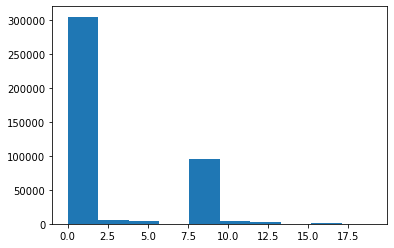

In [8]:
# Have a look at the distribution of target values
plt.hist(y_train_transformed)

In [9]:
# Start encoding the 'dayofweek' column of x_train
le = preprocessing.LabelEncoder() # Create a label encoder for variable "dayofweeek"
le.fit(x_train['dayofweek']) # Fit the values
x_train['dayofweek'] = le.transform(x_train['dayofweek']) # Perform transformation
le.classes_ # have a look at the classes

array(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype=object)

In [10]:
# Create a dummy ID columns to make it compatible with tsfresh library
x_train['dummy_id'] = 1 
x_train.columns # Have a look a column names

Index(['absdif', 'dayofweek', 'dif', 'entropy', 'hourofday', 'hurst', 'id',
       'load', 'max', 'nonlinear', 'var', 'dummy_id'],
      dtype='object')

### 1.3.2 Scaling x_train to mean zero and standard deviation of one

In [11]:
# Standardize features by removing the mean and scaling to unit variance
scale_list = ['absdif', 'dayofweek', 'dif', 'entropy', 'hourofday', 'hurst',
       'load', 'max', 'nonlinear', 'var']
scaler = preprocessing.StandardScaler().fit(x_train[scale_list]) # Fit the data values
x_train[scale_list] = scaler.transform(x_train[scale_list]) # Perform transforming
x_train

,absdif,dayofweek,dif,entropy,hourofday,hurst,id,load,max,nonlinear,var,dummy_id
0,1.633999,-0.006818,1.859011,-0.306037,-1.659524,0.325913,105541,0.031914,1.050126,-0.542338,0.673127,1
1,-0.287489,-0.006818,0.026370,-0.427219,-1.659524,0.327174,105542,0.039319,1.050126,-0.541600,0.728126,1
2,-0.295388,-0.006818,0.018836,-0.635696,-1.659524,0.328183,105543,0.044609,1.050126,-0.540772,0.782525,1
3,-0.313161,-0.006818,-0.001882,-0.832269,-1.659524,0.327108,105544,0.044080,1.050126,-0.540536,0.801349,1
4,-0.311186,-0.006818,0.003768,-0.916324,-1.659524,0.325441,105545,0.045138,1.050126,-0.530947,0.800779,1
...,...,...,...,...,...,...,...,...,...,...,...,...
417715,-0.309212,0.992434,-0.005649,-7.500160,1.375005,-14.864864,523256,0.189539,-1.866220,-0.562601,-1.046775,1
417716,-0.066310,0.992434,-0.237319,-7.500160,1.375005,-14.864864,523257,0.122892,-1.866220,-0.562601,-1.046775,1
417717,2.485141,0.992434,-2.670795,-7.500160,1.375005,-14.864864,523258,-0.627149,-1.866220,-0.562601,-1.046775,1
417718,-0.249967,0.992434,-0.062154,-7.500160,1.375005,-14.864864,523259,-0.644604,-1.866220,-0.562601,-1.046775,1


### 1.3.3 Rolling

In [12]:
# Since the design choice is to use 64 minutes at each time-step, therefore each of the first 63 observations 
# will not have enough 63 observations before it in order to make a series of 64 observations.
# Thus I will add 63 copies of the first observation to the top of the dataframe.
extra_len = pd.DataFrame(x_train.iloc[0:1,:].values.repeat(63, axis = 0), columns=x_train.columns)
extra_len['id'] = list(range(105541-63,105541)) # Adjust the indexes

x_train = pd.concat([extra_len, x_train]) # Concatenate the x_train and the extra data
x_train.reset_index(drop=True, inplace=True)
x_train.head(128)

,absdif,dayofweek,dif,entropy,hourofday,hurst,id,load,max,nonlinear,var,dummy_id
0,1.633999,-0.006818,1.859011,-0.306037,-1.659524,0.325913,105478,0.031914,1.050126,-0.542338,0.673127,1.0
1,1.633999,-0.006818,1.859011,-0.306037,-1.659524,0.325913,105479,0.031914,1.050126,-0.542338,0.673127,1.0
2,1.633999,-0.006818,1.859011,-0.306037,-1.659524,0.325913,105480,0.031914,1.050126,-0.542338,0.673127,1.0
3,1.633999,-0.006818,1.859011,-0.306037,-1.659524,0.325913,105481,0.031914,1.050126,-0.542338,0.673127,1.0
4,1.633999,-0.006818,1.859011,-0.306037,-1.659524,0.325913,105482,0.031914,1.050126,-0.542338,0.673127,1.0
5,1.633999,-0.006818,1.859011,-0.306037,-1.659524,0.325913,105483,0.031914,1.050126,-0.542338,0.673127,1.0
6,1.633999,-0.006818,1.859011,-0.306037,-1.659524,0.325913,105484,0.031914,1.050126,-0.542338,0.673127,1.0
7,1.633999,-0.006818,1.859011,-0.306037,-1.659524,0.325913,105485,0.031914,1.050126,-0.542338,0.673127,1.0
8,1.633999,-0.006818,1.859011,-0.306037,-1.659524,0.325913,105486,0.031914,1.050126,-0.542338,0.673127,1.0
9,1.633999,-0.006818,1.859011,-0.306037,-1.659524,0.325913,105487,0.031914,1.050126,-0.542338,0.673127,1.0


#### Note: Might take 1 hour to run, If you have preprocessed .h5 file, comment the 3 lines, uncomment and run the last line 

Preprocessed data can be downloaded here: https://drive.google.com/drive/folders/1eFRQ70vebFuOiMC7n1k_PU0uK5plU5qM?usp=sharing  
They should be placed in the preprocessed_data folder, and comment+uncomment the code like instructed below

In [13]:
# roll_time_series method creates sub windows of the time series. It rolls the (sorted) data frames for each 
# kind and each id separately in the “time” domain (which is represented by the sort order of the sort column given
# by column_sort).
# For example when applying the roll_time_series to a data [a,b,c,d,e,f,g] with time_shift = 3, the result will be 
# [a,b,c, b,c,d, c,d,e, d,e,f, e,f,g]. The input of the CNN model will have a shape of [64,10] (64 timestep, 10
# variables) and its prediction will be the appliances status at time_step 64.
# Notice: run these lines of code will take hours

x_train_rolled = roll_time_series(x_train, column_id="dummy_id", column_sort="id",
                            max_timeshift = 63, min_timeshift = 63, n_jobs = 16)
# Save the preprocessed data for later re-use
x_train_rolled.to_hdf('./preprocessed_data/x_train_rolled_64.h5','x_train_rolled_64')

# Load the preprocessed data
# x_train_rolled = pd.read_hdf('./preprocessed_data/x_train_rolled_64.h5', 'x_train_rolled_64')

In [14]:
# The training data now has 12531600 observation, which is 64 times bigger than the original dataset, this is 
# because of the rolling method mentioned above.
x_train_rolled = x_train_rolled[['absdif','dayofweek','dif','entropy','hourofday','hurst','id','load','max',
                               'nonlinear','var','dummy_id']] # rearrange the columns
print(len(x_train_rolled)/64) 
print(len(x_train)-63) # minus 63 copies of the 1st rows
# Let's have a look to see if the amount of data is the same as the original one

417720.0
417720


In [18]:
# Next, let's go back to the rolled x_train data
x_train_rolled.tail(64)
# It can be seen that for each 64 observations, they all have the same ID, which mean an observation K and
# K-1, K-2, ... K-63 observation will be used as input for the model to predict the y value of observation K.
# There are 26734080 rows in this dataset, which is 64 times bigger than the original one because that each 
# row and its 63 previous rows will be used with 10 columns to create

,absdif,dayofweek,dif,entropy,hourofday,hurst,id,load,max,nonlinear,var,dummy_id
26734016,-0.315136,1.492060,0.000001,0.461156,-0.359012,0.193999,"(1.0, 523260)",-0.776840,-0.873302,-0.270927,-0.990493,1.0
26734017,-0.228244,1.492060,0.082875,0.421011,-0.359012,0.196559,"(1.0, 523260)",-0.753566,-0.873302,-0.263988,-0.989656,1.0
26734018,0.097599,1.492060,0.393652,0.300433,-0.359012,0.198168,"(1.0, 523260)",-0.643017,-0.873302,-0.266764,-0.989040,1.0
26734019,-0.137403,1.492060,-0.169513,0.179094,-0.359012,0.199278,"(1.0, 523260)",-0.690622,-0.873302,-0.267360,-0.988579,1.0
26734020,-0.196648,1.492060,0.113011,0.148276,-0.359012,0.199824,"(1.0, 523260)",-0.658886,-0.873302,-0.267716,-0.988280,1.0
26734021,-0.293413,1.492060,0.020720,0.194634,-0.359012,0.199960,"(1.0, 523260)",-0.653067,-0.873302,-0.270409,-0.988124,1.0
26734022,-0.242068,1.492060,-0.069688,0.269632,-0.359012,0.199819,"(1.0, 523260)",-0.672638,-0.873302,-0.269190,-0.988086,1.0
26734023,-0.111731,1.492060,0.194001,0.335789,-0.359012,0.199787,"(1.0, 523260)",-0.618157,-0.873302,-0.271062,-0.988100,1.0
26734024,0.121296,1.492060,0.416254,0.370952,-0.359012,0.199026,"(1.0, 523260)",-0.501261,-0.873302,-0.276163,-0.988301,1.0
26734025,-0.247993,1.492060,-0.064038,0.362536,-0.359012,0.197010,"(1.0, 523260)",-0.519245,-0.873302,-0.269598,-0.988946,1.0


In [19]:
x_train_rolled.drop(['id','dummy_id'], axis=1, inplace=True) # drop the ID column
# reshape the rolled x_train to a new shape of [417720,60,10]
# 417720 is the number of observation, 60 is the number of timestep of each input, 10 is number of features
x_train_rolled = np.reshape(x_train_rolled.to_numpy(dtype=np.float64), [-1 , 64, int(x_train_rolled.shape[1])])
x_train_rolled.shape #(417720, 60, 10)

(417720, 64, 10)

### 1.3.4  Extract the Fast Fourier Transform features

In [20]:
x_train_fft = np.copy(x_train_rolled)
x_train_fft = np.apply_along_axis(absfft, 1, x_train_fft)
x_train_fft.shape 

(417720, 33, 10)

There are 33 (*n/2+1*) Fast Fourier Transform values are computed from the 64 (*n*) rows, We will use these FFT as 
another input for our CNN model.

In [21]:
print(x_train_rolled.shape)
print(x_train_fft.shape)

(417720, 64, 10)
(417720, 33, 10)


In [22]:
# Transpose the shape x_train_rolled and x_train_fft to [observations, features, time_steps]
x_train = x_train_rolled.transpose(0,2,1)
x_train_fft = x_train_fft.transpose(0,2,1)
del x_train_rolled # was assigned to x_train, so delete to free some RAM

In [23]:
print(x_train.shape)
print(x_train_fft.shape)

(417720, 10, 64)
(417720, 10, 33)


# 2 Model training

## 2.1 Build datasets and select training device

In [24]:
seed = 7
train_size = len(x_train)
datasets = build_datasets((x_train, x_train_fft), y_train_transformed,
                          train_size = train_size, valid_pct = 0.1, seed=seed)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

There are 20 class in training data
There are 20 class in validating data


## 2.2 Create model, set hyperparameters and start training

In [47]:
# Get the input number of features of the x_raw branch of the model, which is 10
raw_feat = x_train.shape[1]
# Get the input number of features of the x_fft branch of the model, which is 10
fft_feat = x_train_fft.shape[1]
# Get the train and validate dataloaders
trn_dl, val_dl = build_loaders(datasets, batch_size=512, jobs=16)

lr = 0.0002 # Set learning rate
n_epochs = 1000 # Set maximum epoch
iterations_per_epoch = len(trn_dl) # Iteration per epoch
num_classes = 20 # Number of classes
best_acc = 0 # Set best accuracy for later early stopping purpose
best_f1 = 0 # Set best F1_score for later early stopping purpose
patience, trials = 500, 0 # Set patience and a counter for later early stopping purpose
base = 1 # use to efficiently print the loss and accuracy while training 
step = 2 # use to efficiently print the loss and accuracy while training, only print out the accuracy at
         # step 2,4,8,16,32,...
loss_history = [] # For loss storing
acc_history = [] # For accuracy storing
gstep = -1#Global step is used to initiate an One Cycle Learning Rate Scheduler. gstep = -1 means entirely new model
model = Classifier(raw_feat, fft_feat, num_classes,drop = .5).to(device) # Create the CNN model 
criterion = FocalLoss(reduction="sum") # Create loss function
opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay= 0.0001) # Initiate Adam optimizer
# Create a one cycle learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, 0.004, steps_per_epoch = len(datasets[0]),epochs = n_epochs,
                                                  pct_start = 0.4,base_momentum = 0.85, max_momentum=0.95,
                                                  div_factor = 10.0, last_epoch = gstep)
print('Start model training')

for epoch in range(1, n_epochs + 1):
    # Set model to traning mode
    model.train()
    epoch_loss = 0
    # Iterate through every batch of the train data loader
    for i, batch in enumerate(trn_dl):
        # Send the input to training device
        x_raw, x_fft, y_batch = [t.to(device) for t in batch]
        opt.zero_grad()
        out = model(x_raw, x_fft) # Get the output from the model
        loss = criterion(out, y_batch) # Calculate losses
        epoch_loss += loss.item() # Record the loss
        loss.backward() # Back-propagation
        opt.step() # Call step() method to update the parameters
        lr_scheduler.step() # Call step() method to update the parameters
    # average the epoch's loss
    epoch_loss /= train_size
    # Record the loss history
    loss_history.append(epoch_loss)
    # Start validating
    model.eval()
    correct, total, epoch_f1 = 0, 0, []
    for batch in val_dl: # Iterate through every batch of the validating data
        # Send the data to CUDA device
        x_raw, x_fft, y_batch = [t.to(device) for t in batch]
        out = model(x_raw, x_fft) # Get the output from the model
        preds = F.log_softmax(out, dim=1).argmax(dim=1) # Generate final prediction
        # Calculate F1_score of the batch
        batch_f1 = f1_score(y_batch.detach().cpu().clone().numpy(), preds.detach().cpu().clone().numpy(), 
                           average="macro")
        epoch_f1.append(batch_f1)# Record the error
        total += y_batch.size(0)
        correct += (preds == y_batch).sum().item() # calculate the accuracy
    # average the F1_score of all batches to get the validation F1_score
    cur_f1 = np.mean(epoch_f1)
    epoch_f1 = []
    # Get the validating accuracy      
    acc = correct / total
    acc_history.append(acc)

    if epoch % base == 0:
        print(f'Epoch: {epoch:3d}. Loss: {epoch_loss:.4f}. Acc.: {acc:2.2%}')
        base *= step
    # Keep track of the improvement of the model in term of accuracy for early stopping
    if acc > best_acc:
        trials = 0
        best_acc = acc
        # save the model with best accuracy
        torch.save(model.state_dict(), './trained_model/CNN_best_accuracy.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    # Keep track of the improvement of the model in term of F1_score for early stopping
    if cur_f1 > best_f1:
        trials = 0
        best_f1 = cur_f1
        # save the model with best F1_score
        torch.save(model.state_dict(), './trained_model/CNN_best_f1.pth')
        print(f'Epoch {epoch} best F1 saved with F1: {best_f1:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break
            
print('Done!')

Start model training
Epoch:   1. Loss: 0.7772. Acc.: 75.59%
Epoch 1 best model saved with accuracy: 75.59%
Epoch 1 best F1 saved with F1: 13.60%
Epoch:   2. Loss: 0.4346. Acc.: 92.53%
Epoch 2 best model saved with accuracy: 92.53%
Epoch 2 best F1 saved with F1: 19.54%
Epoch 3 best model saved with accuracy: 92.94%
Epoch 3 best F1 saved with F1: 25.75%
Epoch:   4. Loss: 0.2827. Acc.: 93.29%
Epoch 4 best model saved with accuracy: 93.29%
Epoch 4 best F1 saved with F1: 30.77%
Epoch 5 best model saved with accuracy: 93.47%
Epoch 5 best F1 saved with F1: 34.65%
Epoch 6 best model saved with accuracy: 93.50%
Epoch 7 best model saved with accuracy: 93.63%
Epoch:   8. Loss: 0.2524. Acc.: 93.68%
Epoch 8 best model saved with accuracy: 93.68%
Epoch 8 best F1 saved with F1: 36.30%
Epoch 9 best model saved with accuracy: 93.75%
Epoch 10 best model saved with accuracy: 93.82%
Epoch 10 best F1 saved with F1: 37.72%
Epoch 11 best model saved with accuracy: 93.82%
Epoch 13 best model saved with accura

Epoch 489 best model saved with accuracy: 97.23%
Epoch 491 best model saved with accuracy: 97.24%
Epoch 492 best F1 saved with F1: 75.27%
Epoch 505 best model saved with accuracy: 97.29%
Epoch 505 best F1 saved with F1: 75.43%
Epoch: 512. Loss: 0.1173. Acc.: 97.25%
Epoch 521 best model saved with accuracy: 97.31%
Epoch 545 best F1 saved with F1: 75.73%
Epoch 554 best model saved with accuracy: 97.31%
Epoch 554 best F1 saved with F1: 75.99%
Epoch 581 best model saved with accuracy: 97.37%
Epoch 655 best F1 saved with F1: 76.17%
Epoch 663 best F1 saved with F1: 76.66%
Epoch 666 best model saved with accuracy: 97.40%
Epoch 728 best model saved with accuracy: 97.41%
Epoch 763 best model saved with accuracy: 97.42%
Epoch 781 best F1 saved with F1: 76.98%
Epoch 784 best model saved with accuracy: 97.43%
Epoch 792 best model saved with accuracy: 97.46%
Epoch 861 best F1 saved with F1: 77.77%
Epoch 881 best model saved with accuracy: 97.48%
Epoch 911 best model saved with accuracy: 97.49%
Epoc

In [50]:
torch.save(model.state_dict(), './trained_model/CNN_latest.pth') # Save the model after training